# Exploratory Data Analysis of the TIMS Bike Crashes in San Francisco

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')


import tools as ds

In [2]:
crashes_initial = pd.read_csv('data/Crashes.csv')
crashes_initial.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,7034739,2015,2015-08-22,3801,2015-02-26,1931,000985,RICHM,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.458750,37.779350
1,7035304,2014,2015-08-24,3801,2014-12-25,2245,A09861,INGLE,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.418788,37.710855
2,7202472,2016,2016-03-09,3801,2016-02-11,1100,1572,NaN,4,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.395850,37.781310
3,8042422,2016,2016-05-16,3801,2016-04-13,1050,001588,CENTR,3,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.399682,37.794241
4,8046723,2016,2016-05-18,3801,2016-04-16,1614,2472,MISIS,6,5,...,0,0,-,-,NaN,NaN,SAN FRANCISCO,SAN FRANCISCO,-122.429839,37.761200


There are 80 columns describing a bike crash instance, with many containing code words that are interpreted here: https://tims.berkeley.edu/help/SWITRS.php#Codebook

In [3]:
# add columns that are decoded (e.g. weekday 1 = Sunday)
crashes = ds.decode_switrs(crashes_initial)

#ensure date is in dt format
crashes['COLLISION_DATE_CLEAN'] = pd.to_datetime(crashes['COLLISION_DATE'], format = 'mixed', errors = 'coerce')

Created decoded column: WEATHER_1_DESC
Created decoded column: WEATHER_2_DESC
Created decoded column: COLLISION_SEVERITY_DESC
Created decoded column: TYPE_OF_COLLISION_DESC
Created decoded column: ROAD_SURFACE_DESC
Created decoded column: LIGHTING_DESC
Created decoded column: PRIMARY_COLL_FACTOR_DESC
Created decoded column: PCF_VIOL_CATEGORY_DESC
Created decoded column: DAY_OF_WEEK_DESC
Created decoded column: MVIW_DESC


In [4]:
crashes.isna().sum().sort_values(ascending = False).head(30)

CITY_DIVISION_LAPD      5094
TRUCK_ACCIDENT          5049
CALTRANS_DISTRICT       5039
RAMP_INTERSECTION       5039
POSTMILE_PREFIX         5038
ROUTE_SUFFIX            5038
POSTMILE                5038
CALTRANS_COUNTY         5038
LOCATION_TYPE           5036
SIDE_OF_HWY             5008
STATE_ROUTE             5005
MOTORCYCLE_ACCIDENT     5001
LONGITUDE               4977
LATITUDE                4977
PEDESTRIAN_ACCIDENT     4855
ALCOHOL_INVOLVED        4786
DIRECTION               3050
PCF_VIOL_SUBSECTION     2901
PCF_VIOLATION            596
REPORTING_DISTRICT       373
BEAT_NUMBER              347
CHP_VEHTYPE_AT_FAULT     262
TOW_AWAY                 155
POINT_X                  121
POINT_Y                  121
OFFICER_ID                 2
STATE_HWY_IND              1
WEATHER_1                  0
WEATHER_2                  0
DISTANCE                   0
dtype: int64

None of the missing data is pertinent to our exploratory analysis, so we will not drop any records for missing this information.

# Visualizing Bike Collision Trends

In our analysis, we aim to identify general trends across bike collisions, spanning temporal and categorical conditions. In these visuals we explore the impact of the pandemic, time of year, time of day, and several road and accident conditions that are associated with our data's bike crashes.

In [5]:
sns.set_theme(style = "darkgrid", palette = "colorblind")

## Temporal EDA

### Covid 19

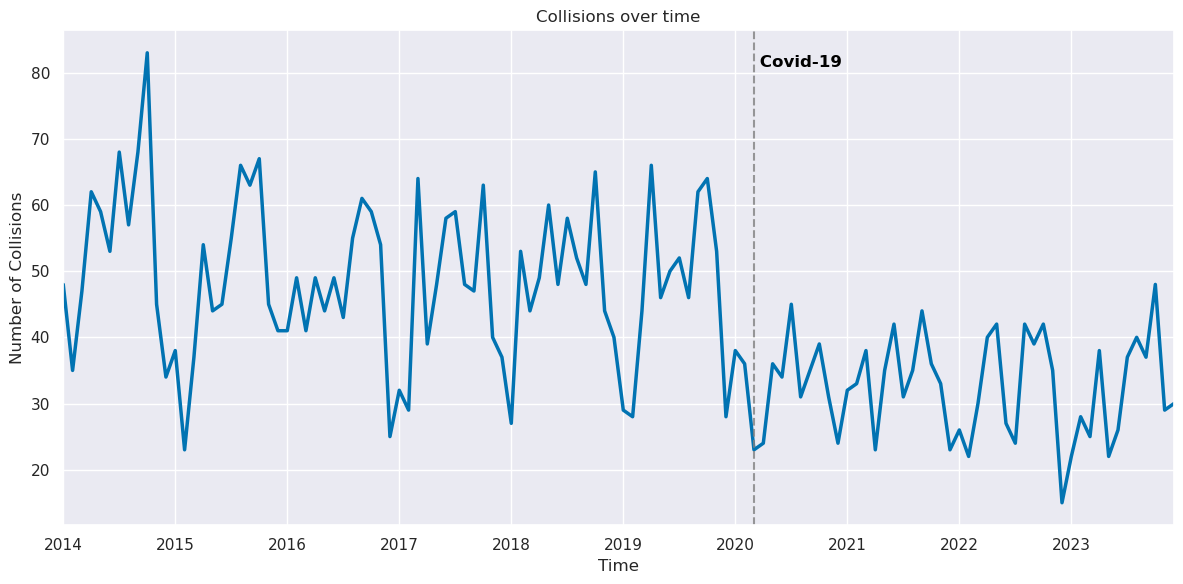

In [6]:
monthly_crashes = crashes.groupby(pd.Grouper(key = 'COLLISION_DATE_CLEAN', freq = 'ME')).size()
fig, ax = plt.subplots(figsize = (12,6))

monthly_crashes.plot(kind= 'line', ax = ax, linewidth = 2.5)


#covid line
ax.axvline(x=pd.Timestamp('2020-03-01'), color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
ax.text(x=pd.Timestamp('2020-03-01'), y=0.95, s=' Covid-19', color='black', transform=ax.get_xaxis_transform(),
         ha='left', va='top', fontweight='bold')


ax.set_title('Collisions over time')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Collisions')
plt.tight_layout()
plt.savefig('figures/Collisions_by_year')
plt.show()



The onset of the pandemic is associated with a significant drop in bike collisions, very likely due to the fact that there was a general drop in people riding bikes in places or times that were higher risk of getting into a collision. We speculate that a number of factors contributed to the decrease in high-risk bike use from the pandemic, such as the initial quarantine, the residual hybrid or remote work, and general changes in transportation habits. Despite the pandemic conditions improving by 2023, we still a slow inertia in returning to pre-pandemic biking conditions.

### Monthly EDA

In [7]:
order = ["January","February","March","April","May","June",
         "July","August","September","October","November","December"]

monthly_crashes = (
    crashes
    .assign(COLLISION_MONTH=crashes["COLLISION_DATE_CLEAN"].dt.month_name())
    .groupby("COLLISION_MONTH")
    .size()
    .reindex(order)
    .reset_index(name="count")
)

monthly_crashes


,COLLISION_MONTH,count
0,January,333
1,February,336
2,March,393
3,April,444
4,May,436
5,June,432
6,July,472
7,August,472
8,September,504
9,October,566


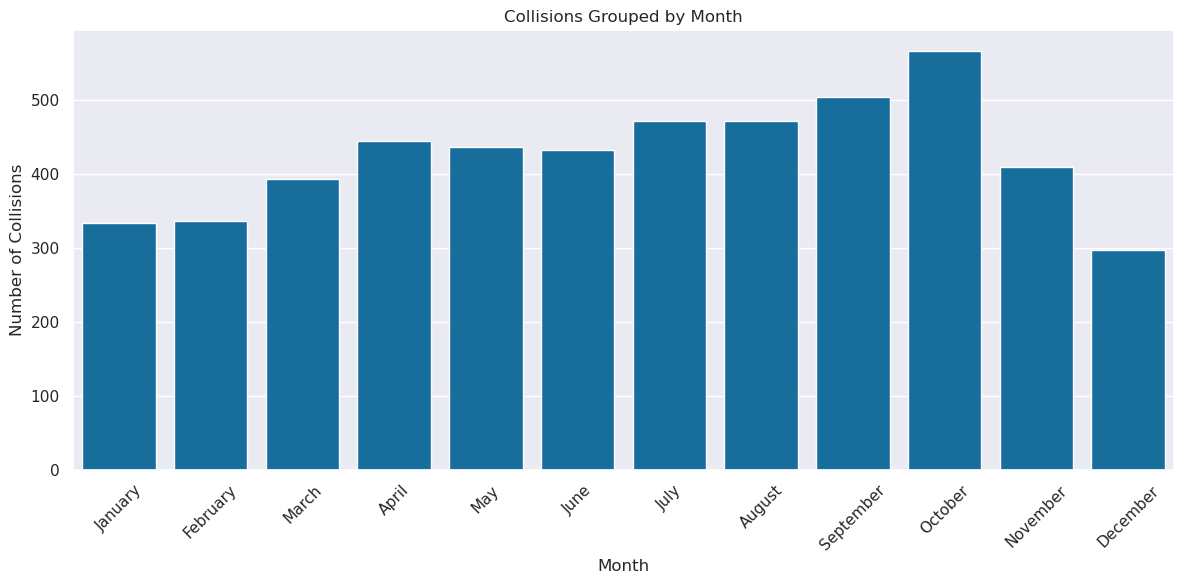

In [8]:
crashes['COLLISION_MONTH'] = crashes['COLLISION_DATE_CLEAN'].dt.month_name()
order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]
monthly_crashes = crashes.groupby(crashes['COLLISION_MONTH']).size().reset_index(name ='count')
monthly_crashes = monthly_crashes.sort_values( by = ['COLLISION_MONTH'], key=lambda column: column.apply(order.index))
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data = monthly_crashes, x = 'COLLISION_MONTH', y = 'count')
ax.set_title('Collisions Grouped by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Collisions')
plt.xticks(rotation=45)
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)
plt.tight_layout()
plt.savefig('figures/Collisions_by_month')
plt.show()


### Seasonal Variation

In [9]:
def season_categories(date):
    month = date.month
    if (month >= 3 and month <= 5):
        return 'Spring'
    elif (month >= 6 and month <= 8):
        return 'Summer'
    elif (month >= 9 and month <= 11):
        return 'Autumn'
    else:
        return 'Winter'


crashes['SEASON'] = crashes['COLLISION_DATE_CLEAN'].apply(season_categories)

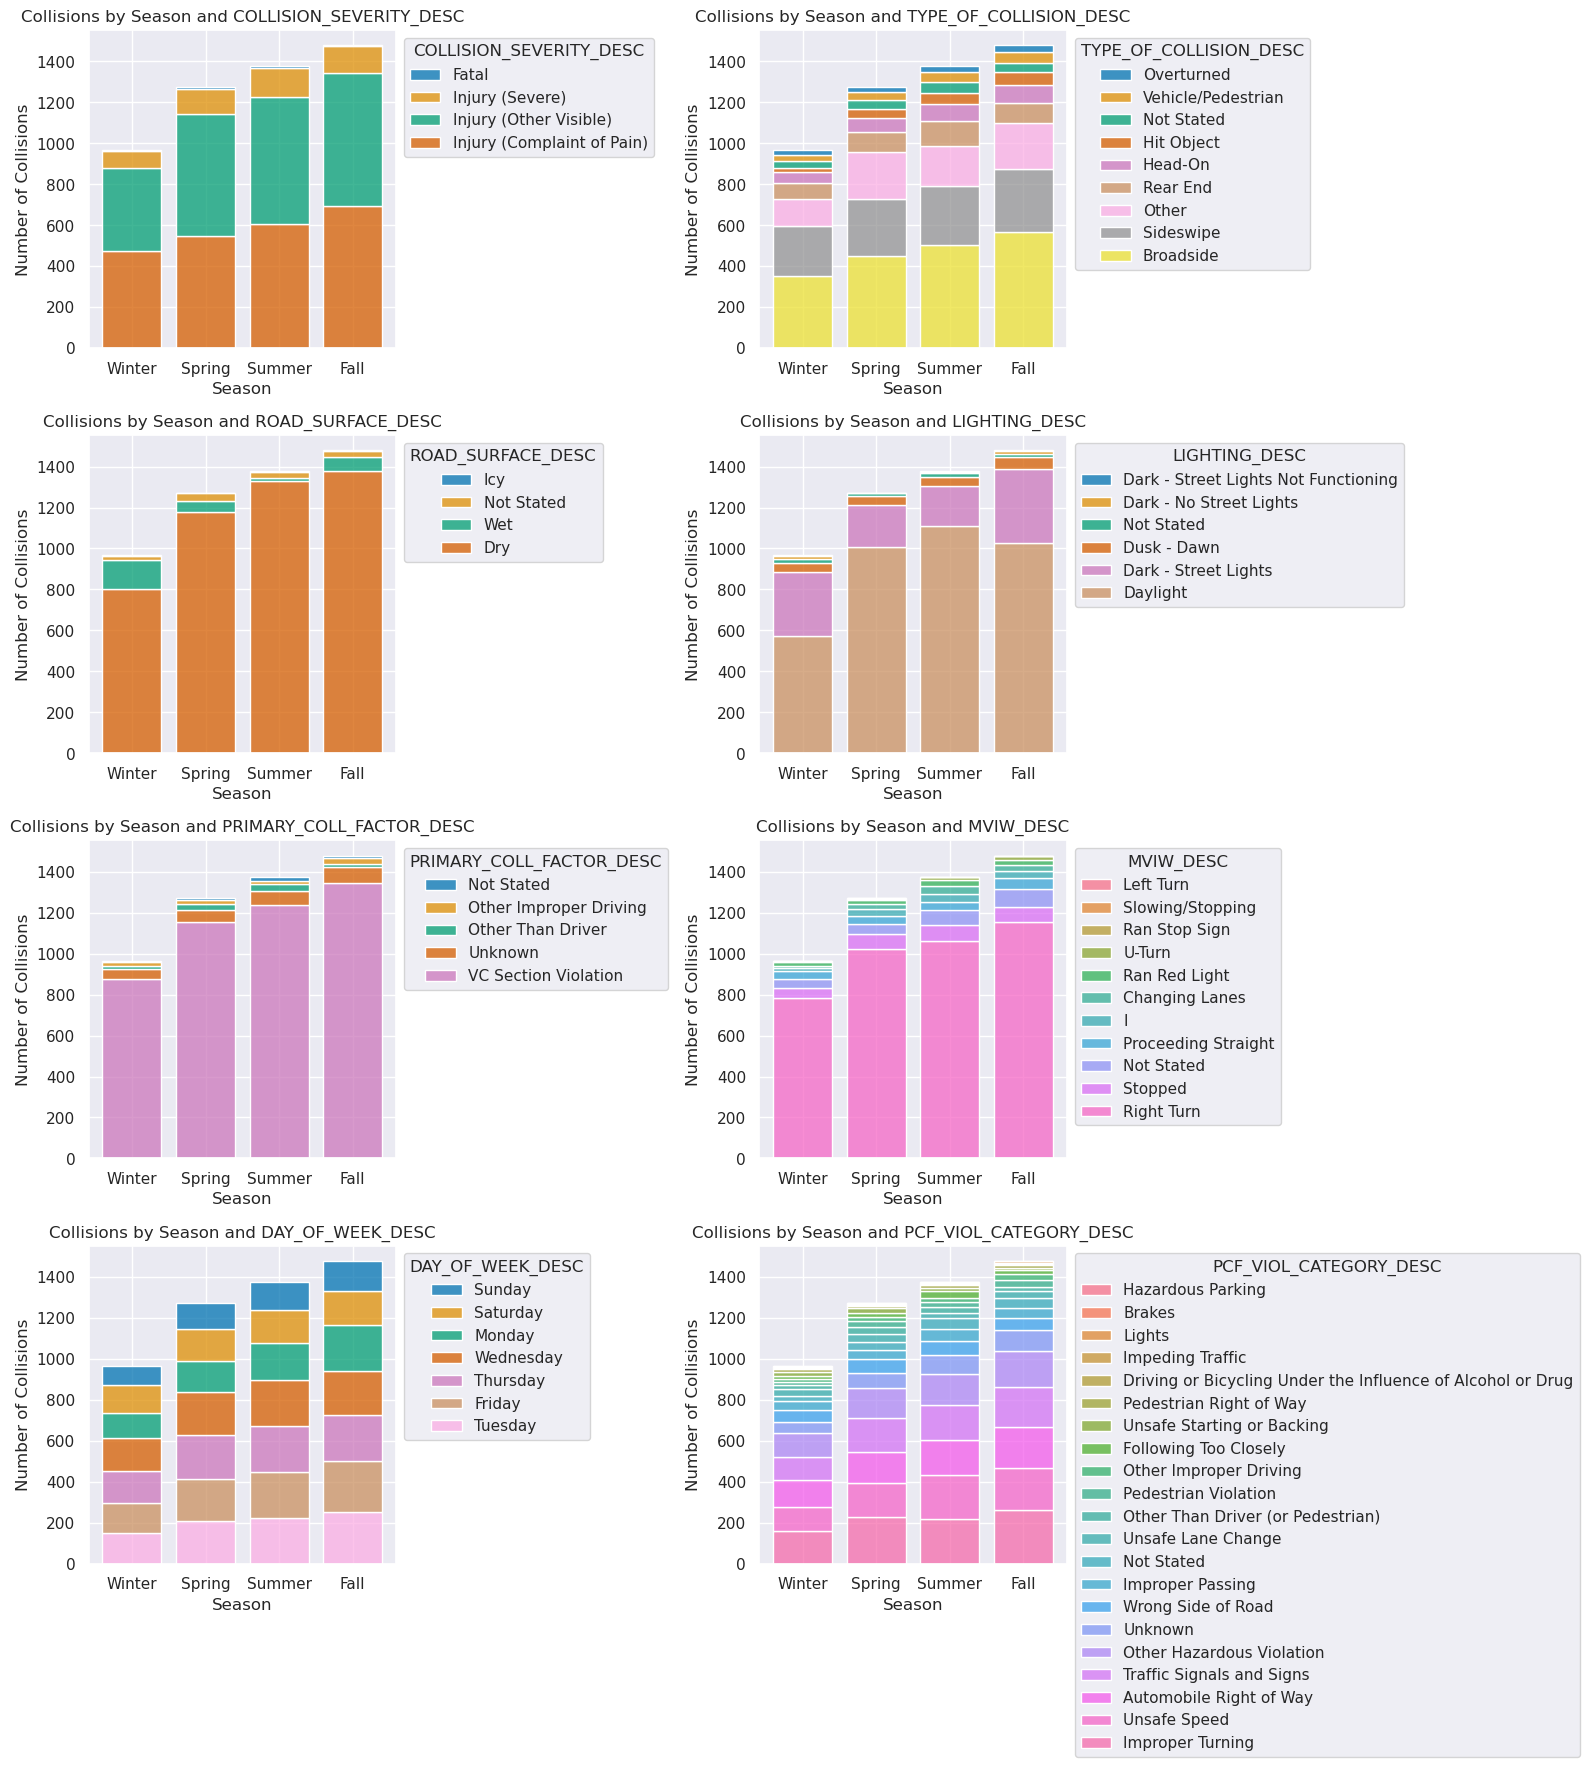

In [10]:
hue_columns = [
    'COLLISION_SEVERITY_DESC', 
    'TYPE_OF_COLLISION_DESC', 
    'ROAD_SURFACE_DESC', 
    'LIGHTING_DESC', 
    'PRIMARY_COLL_FACTOR_DESC',
    'MVIW_DESC',
    'DAY_OF_WEEK_DESC',
    'PCF_VIOL_CATEGORY_DESC'
]

season_order = ['Winter', 'Spring', 'Summer', 'Fall']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))
axes = axes.flatten() #list of 6 axes to help w for loop

for i, col in enumerate(hue_columns):
    ax = axes[i]
    order_by_count = crashes[col].value_counts(ascending=True).index
    
    sns.histplot(
        data=crashes, 
        x="SEASON", 
        hue=col, 
        multiple="stack",
        # keep small vals at top
        hue_order=order_by_count, 
        shrink=0.8,
        ax=ax 
    )
    ax.set_title(f'Collisions by Season and {col}')
    ax.set_xlabel('Season')
    ax.set_ylabel('Number of Collisions')
    ax.set_xticks(range(len(season_order)))
    ax.set_xticklabels(season_order)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# remove empty subplot (6th)
#fig.delaxes(axes[5])

plt.tight_layout()
fig.savefig('figures/Collisions_Categories_by_Season', bbox_inches='tight')
plt.show()

No very obvious differences across seasons, in terms of categorical condition variation, is noted. However, there is certainly a marked differences in the number of crashes per season, with Winter having the lowest and Fall having the highest (cumulatively). We also note that Fall and Winter have more crashes in the dark, likely due to shorter days but unchanging work hours.

### Weekday vs Weekend

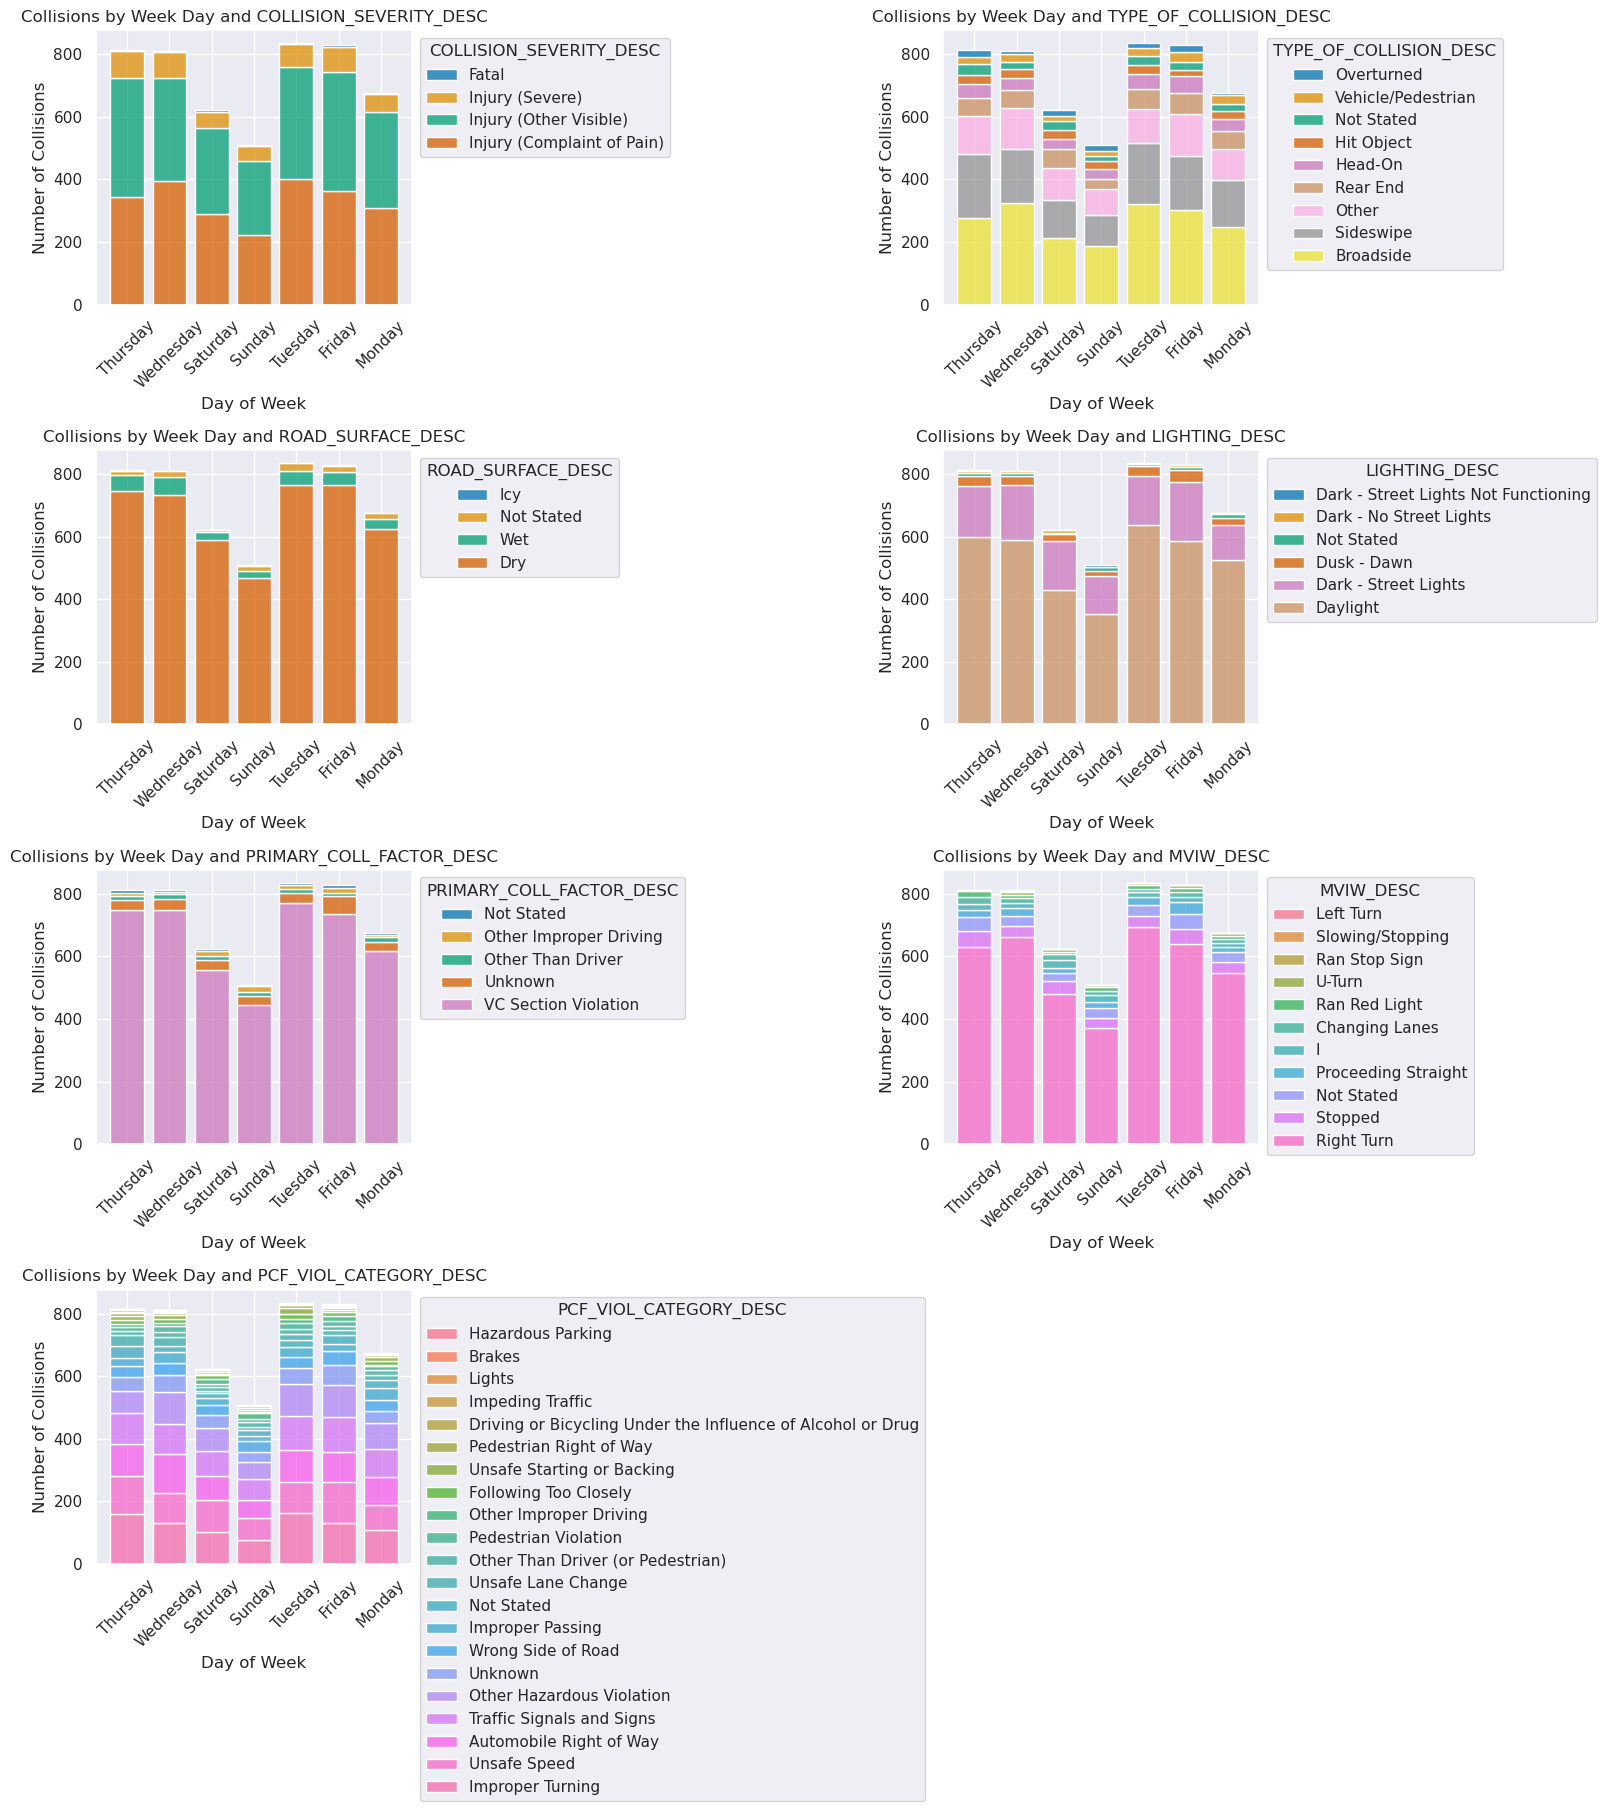

In [11]:
hue_columns = [
    'COLLISION_SEVERITY_DESC', 
    'TYPE_OF_COLLISION_DESC', 
    'ROAD_SURFACE_DESC', 
    'LIGHTING_DESC', 
    'PRIMARY_COLL_FACTOR_DESC',
    'MVIW_DESC',
    'PCF_VIOL_CATEGORY_DESC'
]


#day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))
axes = axes.flatten() #list of 6 axes to help w for loop

for i, col in enumerate(hue_columns):
    ax = axes[i]
    
    
    order_by_count = crashes[col].value_counts(ascending=True).index
    
    sns.histplot(
        data=crashes, 
        x="DAY_OF_WEEK_DESC", 
        hue=col, 
        multiple="stack",
        # keep small vals at top
        hue_order=order_by_count, 
        shrink=0.8,
        ax=ax 
    )
    ax.set_title(f'Collisions by Week Day and {col}')
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Number of Collisions')
    ax.tick_params(axis='x', rotation=45)
    #ax.set_xticks(range(len(day_order)))
    #ax.set_xticklabels(day_order)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# remove empty subplot (8th)
fig.delaxes(axes[7])
#.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/Collisions_Conditions_by_Day')
plt.show()

We conducted the same categorical tests, but across days of the week. We see a noteable difference between the typical Monday - Friday work week with lower collision counts for the typical Saturday and Sunday weekend. 'Recreational' biking, we infer, is less of a contributor to SF's bike collisions as compared to commuting bike accidents, where bikers are commuting in the morning alongside cars and busses.  
  
Next we explore the time of day and how that correlates with bike crashes:

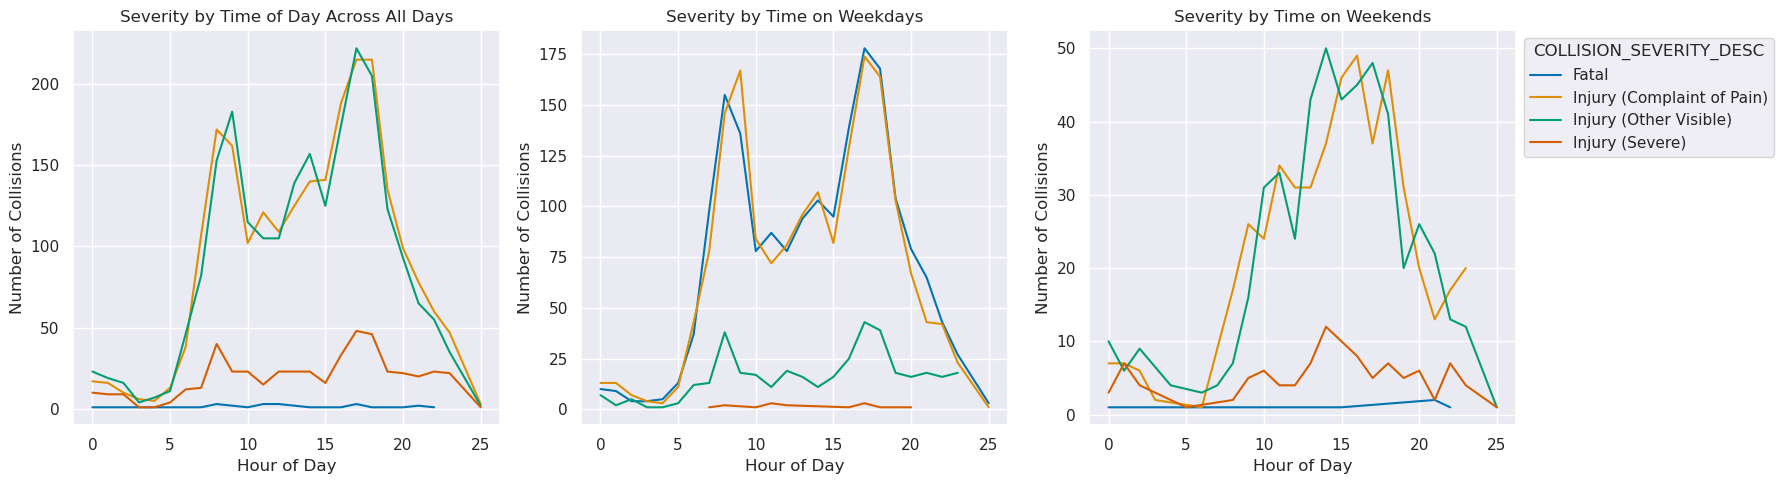

In [12]:
# Extract hour from COLLISION_TIME (HHMM format)
crashes['HOUR'] = crashes['COLLISION_TIME'].astype(str).str.zfill(4).str[:2].astype(int)
weekend = ['Saturday', 'Sunday']

fig, axs = plt.subplots(ncols = 3, figsize = (18,5))

#all days
hour_sev = crashes.groupby(['HOUR', 'COLLISION_SEVERITY_DESC']).size().reset_index(name='count')
sns.lineplot(data = hour_sev, x = 'HOUR', y = 'count',hue = 'COLLISION_SEVERITY_DESC', ax = axs[0], legend = False)
ax = axs[0]
ax.set_title("Severity by Time of Day Across All Days")
ax.set_xlabel("Hour of Day")
ax.set_ylabel('Number of Collisions')


#weekdays
hours_wkday = crashes.loc[~crashes["DAY_OF_WEEK_DESC"].isin(weekend)]
hrs_wkday = hours_wkday.groupby(['HOUR', 'COLLISION_SEVERITY_DESC']).size().reset_index(name='count')
sns.lineplot(data = hrs_wkday, x = 'HOUR', y = 'count', hue = 'COLLISION_SEVERITY_DESC', ax = axs[1], legend = False)
ax= axs[1]
ax.set_title("Severity by Time on Weekdays")
ax.set_xlabel("Hour of Day")
ax.set_ylabel('Number of Collisions')



#weekends
hours_wkend = crashes.loc[crashes["DAY_OF_WEEK_DESC"].isin(weekend)]
hrs_wkend = hours_wkend.groupby(['HOUR', 'COLLISION_SEVERITY_DESC']).size().reset_index(name = 'count')
sns.lineplot(data = hrs_wkend, x = 'HOUR', y = 'count',hue = 'COLLISION_SEVERITY_DESC', ax = axs[2])
ax= axs[2]
ax.set_title("Severity by Time on Weekends")
ax.set_xlabel("Hour of Day")
ax.set_ylabel('Number of Collisions')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.tight_layout()
plt.savefig('figures/Collisions_by_TOD')
plt.show()

Here we see that weekday crashes are markedly near morning and evening commute time of the 9-5 workday, while weekends follow a more normal distribution. The overwhelming majority of weekday crashes mean that the cumulative collision by time of day graph follows most closely with the weekday trends.

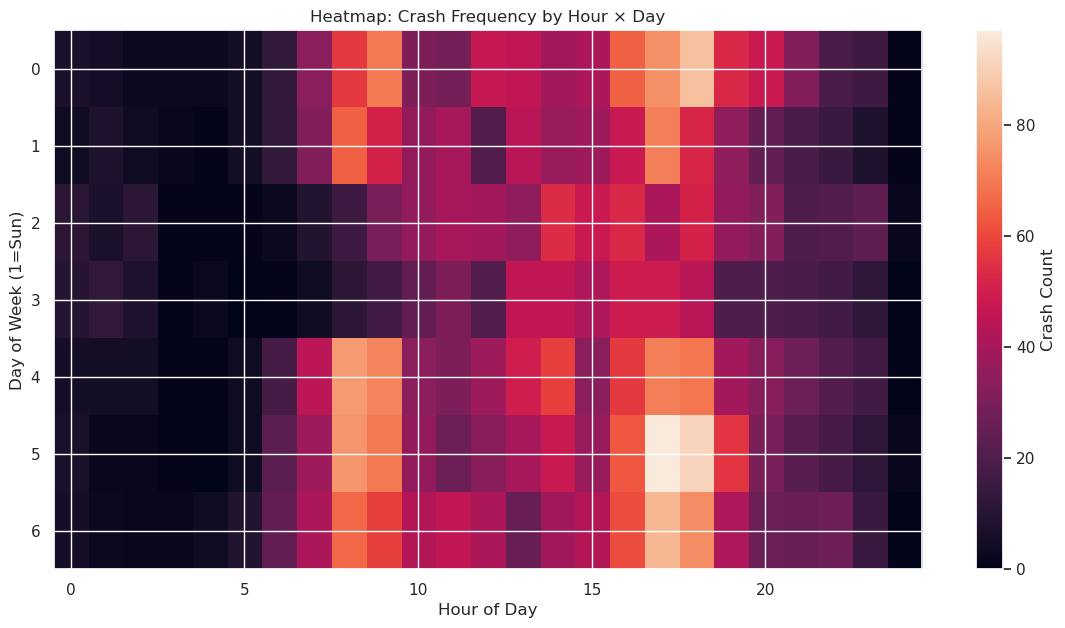

In [13]:
crashes['HOUR'] = crashes['COLLISION_TIME'].astype(str).str.zfill(4).str[:2].astype(int)

pivot = crashes.pivot_table(
    values='CASE_ID',
    index='DAY_OF_WEEK_DESC',
    columns='HOUR',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(14,7))
plt.imshow(pivot, aspect='auto')
plt.colorbar(label="Crash Count")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (1=Sun)")
plt.title("Heatmap: Crash Frequency by Hour × Day")
plt.savefig('figures/Crash_Heatmap')
plt.show()


## Fatal Crashes EDA

Total crashes: 5094
Fatal crashes: 23


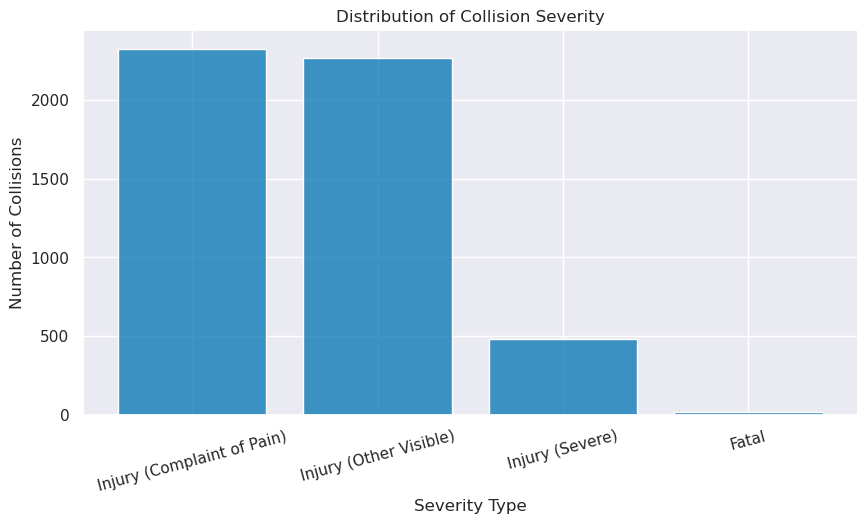

In [14]:
#severity = crashes['COLLISION_SEVERITY'].dropna().astype(int)

# Fatal crashes defined when NUMBER_KILLED > 0
fatal_crashes = crashes[crashes['NUMBER_KILLED'] > 0]

print("Total crashes:", len(crashes))
print("Fatal crashes:", len(fatal_crashes))

plt.figure(figsize=(10, 5))
sns.histplot(
        data=crashes, 
        x="COLLISION_SEVERITY_DESC",
        shrink = 0.8
    )
plt.title("Distribution of Collision Severity")
plt.xlabel("Severity Type")
plt.xticks(rotation = 15)
plt.ylabel("Number of Collisions")
plt.savefig('figures/Distr_Collision_Severity', bbox_inches='tight')
plt.show()

Thankfully, the share of fatalities and severe injuries from bike crashes are extremely low compared to minor injuries.

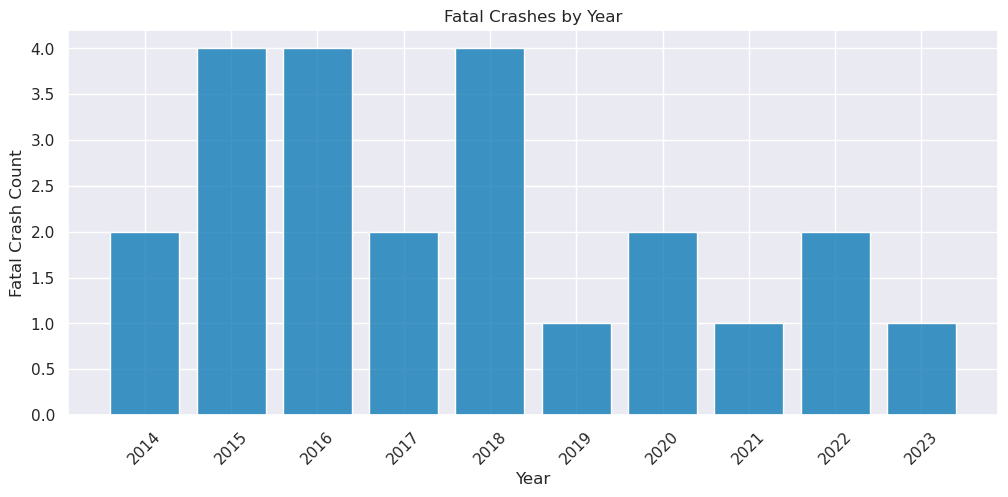

In [15]:
plt.figure(figsize=(12, 5))

sns.histplot(
    data=fatal_crashes,
    x= "ACCIDENT_YEAR",
    shrink= 0.8,
    discrete= True
)
plt.title("Fatal Crashes by Year")
plt.xlabel("Year")
plt.ylabel("Fatal Crash Count")

# force axis to show all years
unique_years = sorted(fatal_crashes['ACCIDENT_YEAR'].unique())
plt.xticks(unique_years, rotation=45) 
plt.savefig('figures/Fatalities_by_year', bbox_inches='tight')
plt.show()

We see a a general smaller number of deaths in pandemic years, but given the small data and small fatality numbers, it is hard to make any conclusions.

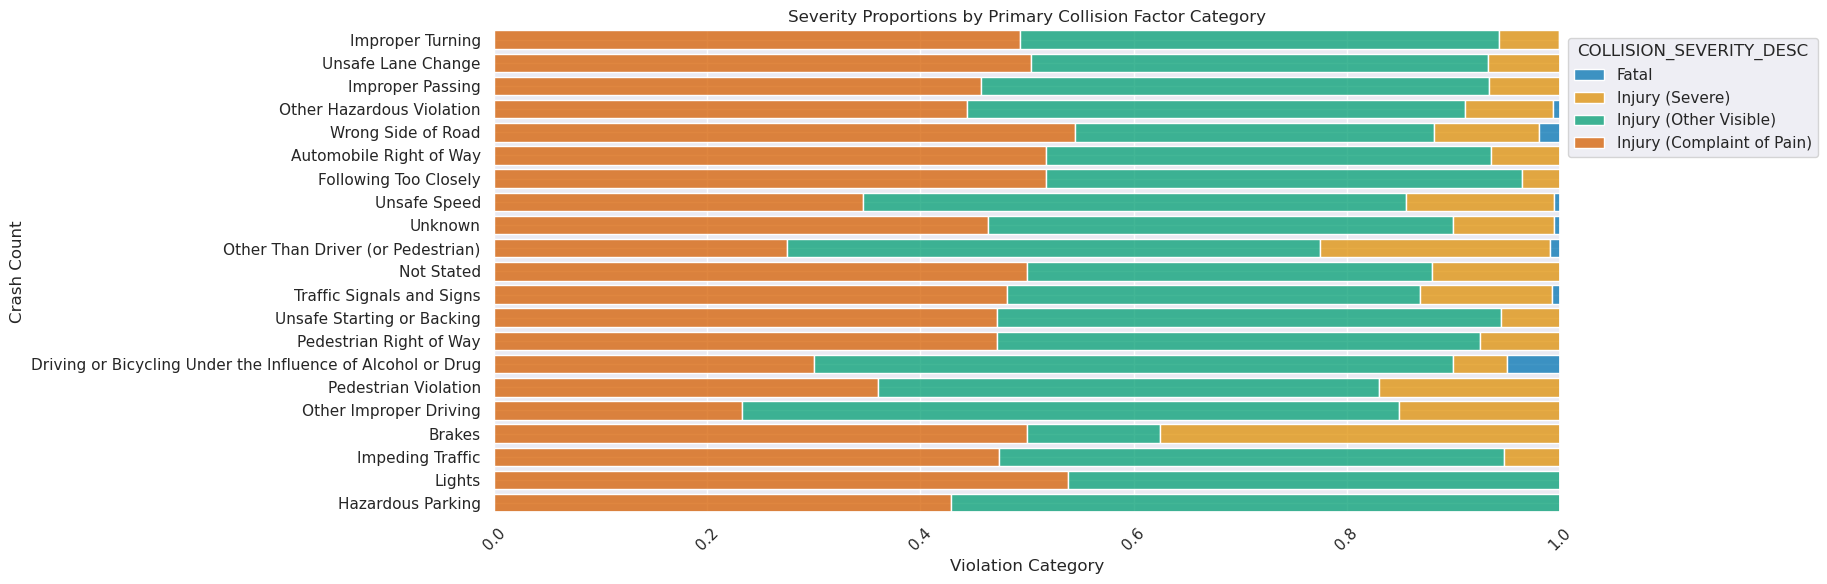

In [16]:
#severity by primary collision factor category
#pcf_sev = crashes.groupby(['PCF_VIOL_CATEGORY', 'COLLISION_SEVERITY']).size().unstack(fill_value=0)
plt.figure(figsize = (16, 6))
order_by_count = crashes['COLLISION_SEVERITY_DESC'].value_counts(ascending=True).index
ax = sns.histplot(
    data = crashes,
    y = 'PCF_VIOL_CATEGORY_DESC',
    hue = 'COLLISION_SEVERITY_DESC',
    hue_order = order_by_count,
    multiple = 'fill',
    stat = 'proportion',
    shrink = 0.8
)

plt.title("Severity Proportions by Primary Collision Factor Category")
plt.xlabel("Violation Category")
plt.ylabel("Crash Count")
plt.xticks(rotation=45)
plt.tight_layout()
sns.move_legend(ax, loc = "upper left", bbox_to_anchor=(1, 1))
plt.savefig('figures/Collis_Factor_Proportions', bbox_inches='tight')
plt.show()


When looking at severity proportions by collision factors, a few things come to light. BUI's (Biking Under the Influence), biking on the wrong side of road, brake malfunctions, conditions other outside of the biker's control seem to have higher proportions of crash severity.

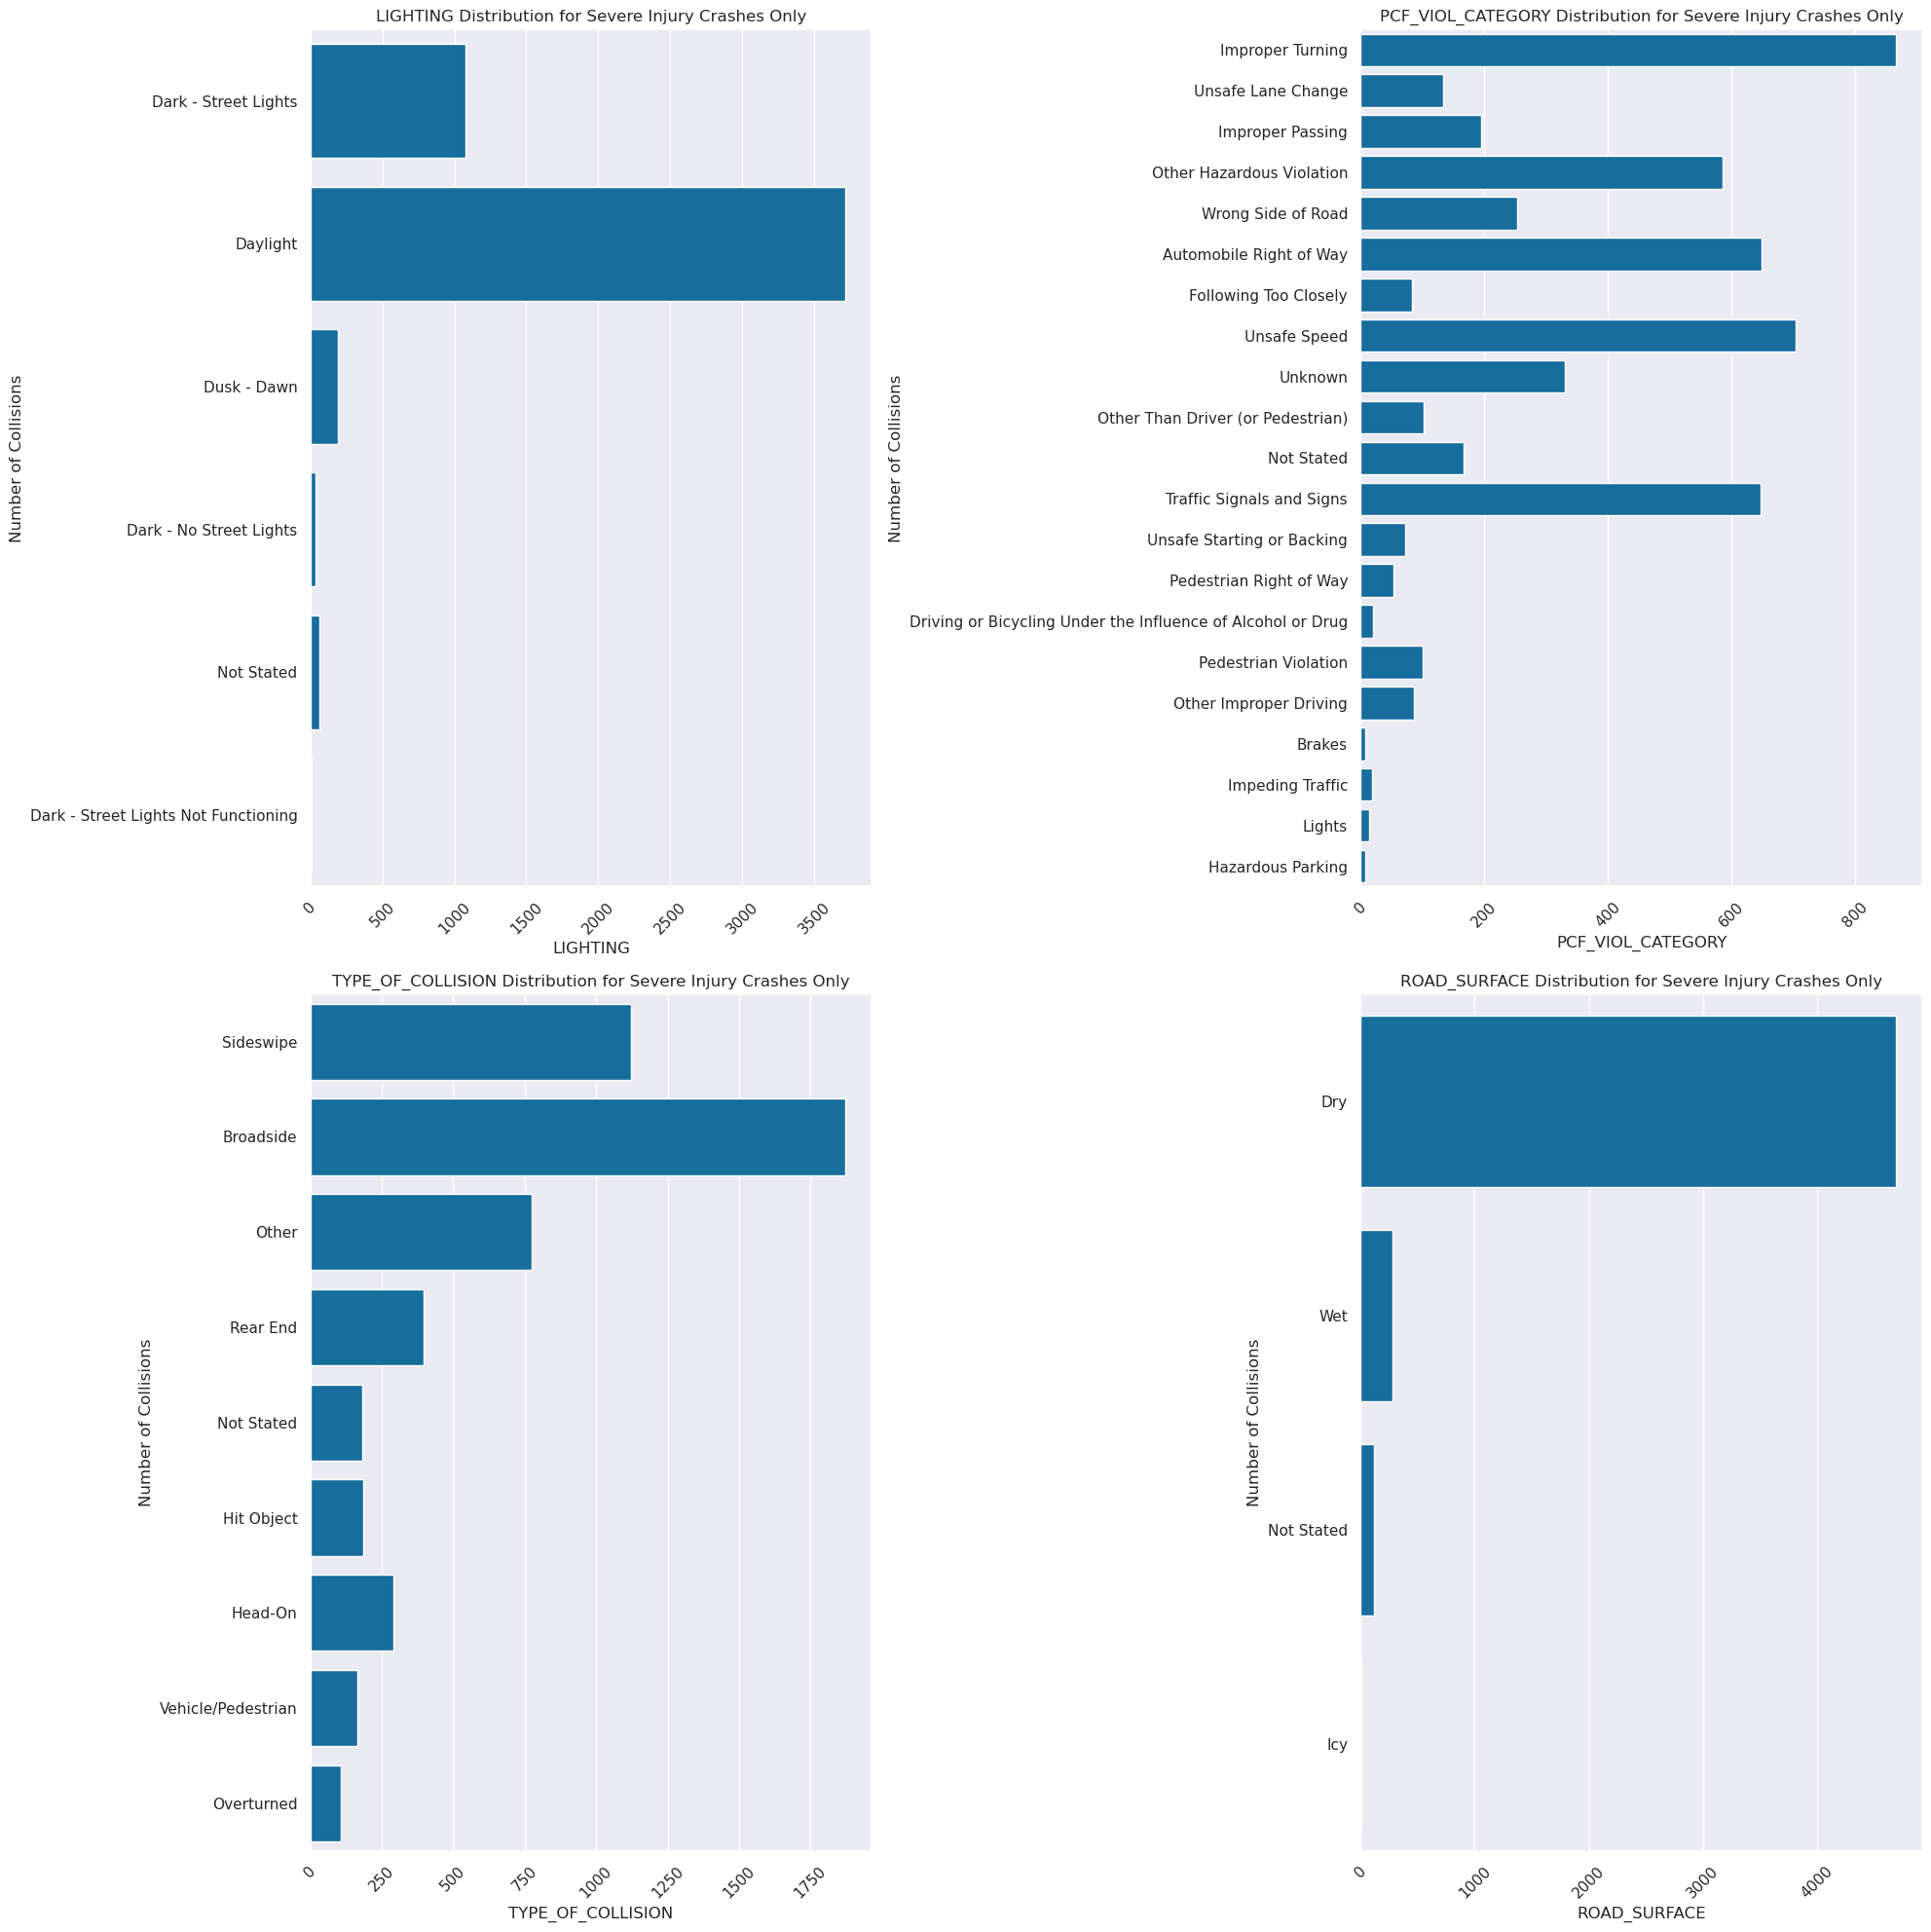

In [17]:
severe = crashes[crashes['COUNT_SEVERE_INJ'] > 0]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes = axes.flatten() #list of 6 axes to help w for loop
cols = ['LIGHTING', 'PCF_VIOL_CATEGORY', 'TYPE_OF_COLLISION', 'ROAD_SURFACE']
for i, col in enumerate(cols):
    ax = axes[i]
 
    if col != 'REPORTING_DISTRICT':
        coldesc = col + '_DESC'
    else:
        coldesc = col
    sns.countplot(ax = ax, data=crashes, y=coldesc)
    ax.set_title(f"{col} Distribution for Severe Injury Crashes Only")
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Number of Collisions')
    ax.tick_params(axis='x', rotation=45)
    

plt.tight_layout()
plt.savefig('figures/Severe_Conditions', bbox_inches='tight')
plt.show()

